# Usage manual
 This Jupyter notebook will walk you through the common foreseen usage cases of this simulation package.
 It will show the workflow from setting up to visualising the output data.
 For details on function calls and class designs, inspection of the code is encouraged.


### Agenda
The software is aimed to give a transparent and reliable grasp on the continuum model for the FEBID process. This flexible simulation package lets user change properties of a precursor, directly observe their influence on the resulting precursor coverage and growth rate profiles, run series of virtual experiments (as well in parallel), save them and open later for analysis. The simulation is based on a steady-state solution of the *Reaction-Diffusion Equation* assuming stationary exposure. 
Package includes a simple *Secondary electron* flux estimator and a feature to set beam profile shape.
For a better understanding of the concepts and variable naming, refer to corresponding articles:
1. Continuum models of focused electron beam induced processing, Beilstein J. Nanotechnol. 2015, 6, 1518–1540.
2. Lateral resolution in focused electron beam-induced deposition: scaling laws for pulsed and static exposure, Appl. Phys. A 2014, 117, 1715–1726.
3. Determination of the surface diffusion coefficient and the residence time of adsorbates via local focused electron beam induced chemical vapour deposition - Journal of Nanoscience and Nanotechnology, 2011, 11(9), 8074-8078

### Setting up
The very first thing is to make sure all the packages from `requirements.txt` are installed.

You might need to change the configuration of PyOpenCl if you intend to use GPU.

### 1. Basic use case

The simulator works on a principle of independent *Experiments*. An *Experiment* is set up with a number of parameters, that are needed to solve the *Reaction-Diffusion Equation (RDE)*, that include precursor parameters, beam parameters and grid. 
Further on, all the operations on these parameters will be done via their class names:

In [6]:
from backend.processclass import Experiment2D

pr = Experiment2D()

# Precursor
pr.n0 = 2.7  # 1/nm^2
pr.F = 730.0  # 1/nm^2/s
pr.s = 1.0
pr.V = 0.05  # nm^3
pr.tau = 700e-6  # s
pr.D = 1e6  # nm^2/s
pr.sigma = 0.02  # nm^2
# Beam
pr.f0 = 1.0e7
pr.fwhm = 200  # nm
# Grid
pr.step = 0.1  # nm - grid resolution

After all the necessary parameters are set, the solution for the steady state can be found:

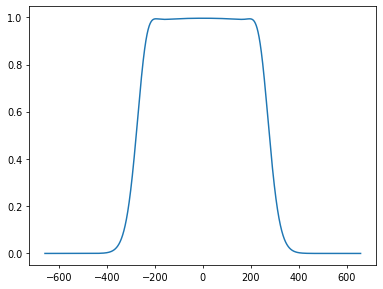

In [9]:
pr.solve_steady_state()
pr.plot('R', dpi=70)

Plotted graph is the dimensionless growth rate profile.

The Experiment `pr` can be saved to a file and opened in any arbitrary script by unpickling: 


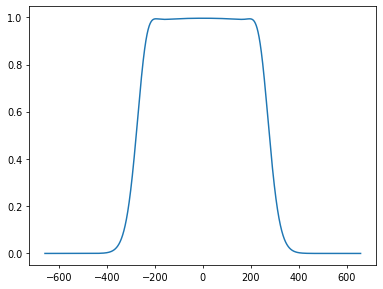

In [12]:
from pickle import load

pr.save_to_file('experiment_test.obj')

with open('experiment_test.obj', mode='rb') as f:
    pr1 = load(f)
    pr.plot('R', dpi=70)

### 2. Parameters

User can set a number of parameters, corresponding to precursor properties, conditions and simulation settings.
Those parameters are used to calculate process attributes, that can only be read. 
The system works like excel formulas: changing one of the parameters will re-calculate all the dependent values.

#### 2.1 Beam settings

It is possible to set up the beam via gaussian standard deviation `st_dev` and center beam intensity `f0`. Note: beam FWHM and standard deviation are interconnected. Setting one value will recalculate the other.

In [18]:
pr.f0 = 1e6
pr.st_dev = 5
pr.fwhm

11.775

By default, the beam intensity profile corresponds to gaussian distribution:

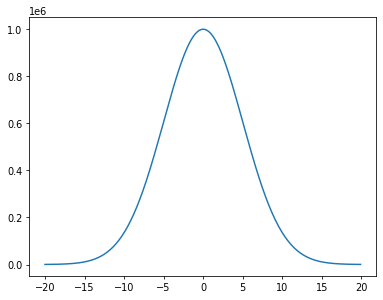

In [20]:
pr.get_beam(pr.get_grid(pr.st_dev*4))
pr.plot('f', dpi=70)

Flat-top beams are also supported:

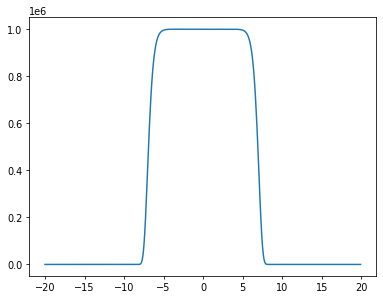

In [21]:
pr.beam_type = 'super_gauss'
pr.order = 8
pr.get_beam(pr.get_grid(pr.st_dev*4))
pr.plot('f', dpi=70)

In [16]:
pr.order = 1
pr.beam_type = 'gauss'

### 2.2 Process attributes

The *Experiemnt* automatically calculates process parameters like *Depletion* `tau_r` and *Diffusive replenishment* `p_o`

In [3]:
print(pr.tau_r)
print(pr.p_o)
print(pr.p_i)

38.94799718903724
2.092635099434147
0.3353134239986766


and others. The process parameters are recalculated automatically, if any of the set parameters are changed.

The class *Experiment2D* is based on a *ContinuumModel* class that actually implements calculation of all process parameters and time discretization required for the numerical solution.
Extending functionality of the *ContinuumModel* class will automatically extend functionality of the whole simulation.


### 3. Performing Experiment

Next, an experiment or numerical solution of the *RDE* can be carried out:

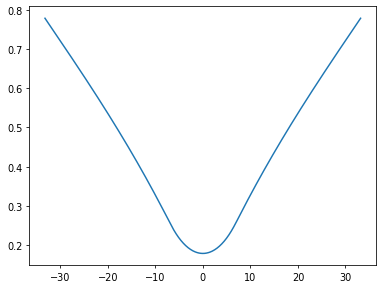

In [22]:
# Obtain a numerical solution for the precursor coverage
n = pr.solve_steady_state()

pr.plot('n', dpi=70)

The result is a precursor coverage profile corresponding to steady-state conditions during stationary exposure.

In this case, grid and beam profiles were generated automatically, but it is possible to override it by providing them to the `pr.solve_steady_state` function.

Internally, the function first calculates an analytical solution of the *Reaction equation* (without diffusion) and uses it as an initial guess for a numerical calculation.
Just like grid and beam profile, initial guess can be specified with `n_init` argument.

After the solution has been obtained, it is also possible to view the normalised *growth rate* by providing 'R' in `pr.plot`.

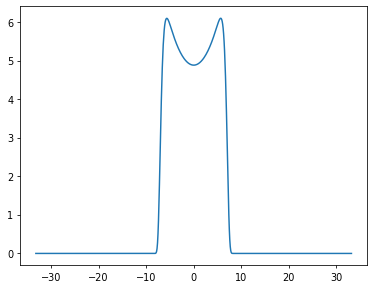

In [23]:
pr.plot('R', dpi=70)

It is also possible to view *beam profile* by using 'f' in `pr.plot`.

*Experiment2D* class has just the basic plotting capabilities. In order to plot more features, the user is encouraged to take plotting function as a basis.

### 3. Analysing profiles

After the solution has been obtained, the normalised growth rate profile can be analyzed:

In [6]:
print(pr.r_max) # position of the highest point of the profile
print(pr.R_max) # maximum profile height
print(pr.R_0) # profile height at the center
print(pr.R_ind) # relative indent or (R_max-R_0)/R_max

6.194037738858435
1.7870006431783354
1.3590072058709197
0.23950379589466309


Note: the analysis uses interpolation. 
These values are not taken from the obtained array of growth rate, but are first interpolated using a cubic function. 
This allows to overcome a low grid discretization problem and provides an opportunity to increase solution speed by decreasing grid discretization.

For custom analysis, obtain the profile data:

In [7]:
r = pr.r # grid
R = pr.R # normalized growth rate

### 4. Saving/loading an Experiment

After performing a calculation, the whole *Experiment* can be saved to a file:

In [8]:
pr.save_to_file('example_experiment.obj')

and loaded via `pickle`:

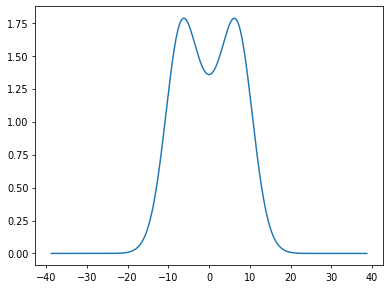

In [24]:
from pickle import load

with open('example_experiment.obj', mode='rb') as f:
    pr1 = load(f)

pr1.plot('R', dpi=70)

### 4a. Alternative solution

While the equation in the *Experiment8 class uses a conventional *RDE*, the same problem can be formulated in a dimensionless equation. Unlike the standard *RDE* with at least 6 input parameters, it uses just two: *depletion* and *diffusive replenishment*.

A basic setup for the alternative solution looks like this:

In [25]:
from backend.processclass2 import  Experiment2D_Dimensionless

pr_d = Experiment2D_Dimensionless()
pr_d.step = 1
pr_d.tau_r = 100
pr_d.p_o = 2
pr_d.fwhm = 200
pr_d.f0 = 1e7
pr_d.solve_steady_state(eps=1e-8)
pr_d.plot('R', dpi=70)

NameError: name 'Experiment2D_Dimensionless' is not defined

By tuning the parameters in the standard *Experiment* to produce same `tau_r` and `p_o`, one can observe that the solutions are identical.

### 5. Running series of experiments

In order to examine a cross correlation between precursor parameters, process parameters and growth rate profiles, a series of *Experiments* with a varied parameter are required.

A class *ExperimentSeries2D* enables storing and basic analysis of several *Experiments*.


In [10]:
from experimentsclass import ExperimentSeries2D

# 1. Create Extepriments instance
exps = ExperimentSeries2D()
# 2. Attach an experiment
exps.add_experiment(pr)

An example of a script running a series of experiments may look like this:

In [11]:
import numpy as np
from backend.experimentsclass import loop_param
# First it is essential to create a simple Experiment and set initial parameters
# This is done exactly like it was shown above

# Next a varied variable name and values should be defined
name = 'D'
vals = np.arange(1e4, 7e5, 5e4)

# Now, series of experiments can be run by consequently varying the surface diffusion parameter.
# Here, a ready-to-go function is used, that iterates over the values, sets them in the Experiment instance, solves RDE and collects all the Experiments
exps = loop_param(name, vals, pr)

Just like a single *Experiment*, *ExperimentSeries* has a basic plotting feature:

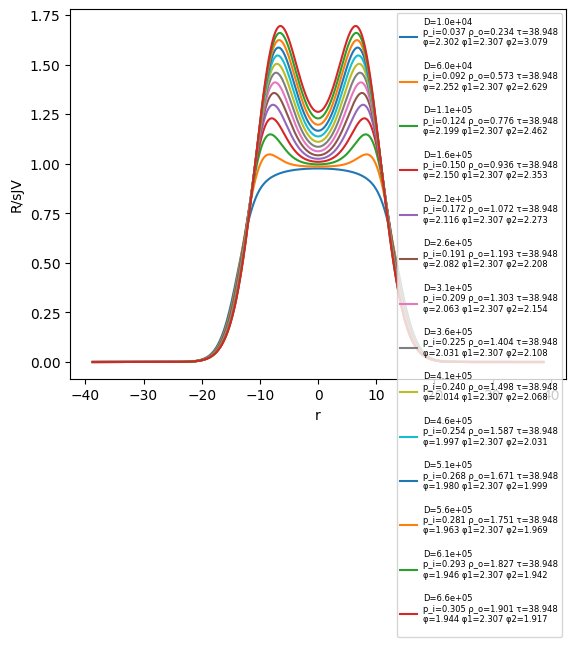

In [12]:
exps.plot('R')

After simulations of the experiments are finished, it is possible to extract a parameter from each experiment in a form of an array:

In [13]:
diff_coeff = exps.get_attr('D')
print(diff_coeff)

[ 10000.  60000. 110000. 160000. 210000. 260000. 310000. 360000. 410000.
 460000. 510000. 560000. 610000. 660000.]


The class also enables extraction of basic profile features of the normalized growth rate like peak height and indented profile features like peak distance from the center and relative indent depth:

In [23]:
fwhm = exps.get_attr('fwhm_d')
r_max = exps.get_attr('r_max')
R_ind = exps.get_attr('R_ind')
print(r_max)

[5.78081375e-06 8.33820199e+00 8.19630774e+00 7.96326580e+00
 7.74478674e+00 7.54832039e+00 7.37151681e+00 7.21113386e+00
 7.06427706e+00 6.92869589e+00 6.80249739e+00 6.68419552e+00
 6.57258361e+00 6.46667407e+00]


Any of the parameters including these profile features can then be plotted against the varied (scanned) parameter or against any of the process parameters:

C:\Users\sandr\PycharmProjects\febid_2d\program.py:84: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  line = ax.scatter(x, y, c=color, cmap='magma')


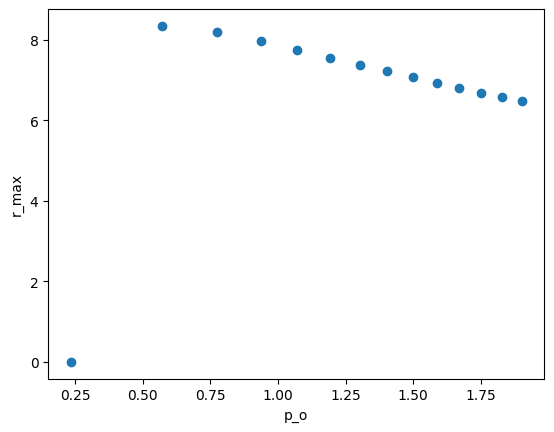

In [15]:
# Here, a prepared function is used for plotting:
from backend.plotting import plot_from_exps

plot_from_exps(exps, 'p_o', 'r_max')

Series of Experiments can be saved and loaded just like a simple Experiment:

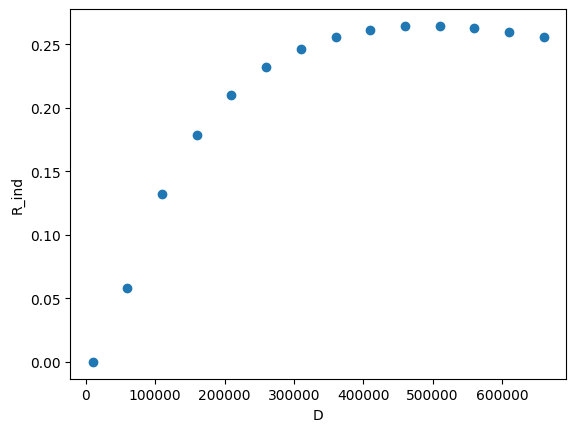

In [16]:
exps.save_to_file('example_experiments.obj')

with open('example_experiments.obj', mode='rb') as f:
    exps1 = load(f)

plot_from_exps(exps1, 'p_o', 'r_max')

### 7. Creating a map

Mapping requires variation of two parameters to create a 2D grid for the third parameter.
For this purpose a `map_2d` function is presented.

In [17]:
from tau_p_o_mp import map_2d
# There is also a version that can take advantage of multiprocessing:
from tau_p_o_mp import map_2d_mp

Here is an example of how to set up and launch a mapping task.
The varied parameters are surface diffusion coefficient `D` and electron flux `f0`.

In [1]:
pr = Experiment2D()
# Initializing model
pr.n0 = 2.7  # 1/nm^2
pr.F = 730.0  # 1/nm^2/s
pr.s = 1.0
pr.V = 0.05  # nm^3
pr.tau = 2000e-6  # s
pr.D = 0 # nm^2/s
pr.sigma = 0.02  # nm^2
pr.f0 = 1e3
pr.fwhm = 50  # nm
pr.order = 1
pr.step = 0.1  # nm
pr.beam_type = 'super_gauss'
pr.order = 4
param_name1 = 'D'
param_name2 = 'f0'
vals1 = np.array([1e3, 1e4, 1e5])
vals2 = np.array([1e5, 1e6, 1e7])
map_2d(pr, (param_name1, param_name2), (vals1, vals2), fname='exps_temp', backend='gpu')

NameError: name 'Experiment2D' is not defined

The script saves experiment series to files, that can then be opened and processed via a separate module. 
By default, if no path is specified, the script saves files to the directory of the script. Note that script will not automatically create folders.

The same setup will also work for multiprocessing, you just need to specify one more argument — numer of processes to use `n_threads`. Multiprocessing will likely not work in Jupyter Notebook.
Using multiprocessing with `gpu` will have the same effect. You might need to run a couple of benchmarks to find an optimal number of processes.

Due to high computational expenses of mapping, user is encouraged to choose the grid resolution mindfully.
Mapping a fine grid may take a week to conclude.
Be aware, that computational complexity increases proportionally to the diffusion coefficient and so does the computational time. 

### 8. Analyzing data

After data has been generated, it can be opened for post-processing and extraction.
Any of the parameters, process attributes and growth rate curve features can be extracted from the simulation files.

In the following example, diffusive replenishment attribute, depletion attribute and relative indent value are extracted from the saved files.
Then it creates a text file with the data and plots the map from the text file:

In [18]:
# import os
# from raw_to_data import filter_and_sort,plot_graph_from_data
# from file_io import write_to_file
#
# Folder with simulation files
# dir = 'user_path' 
# Name of the text file
# output_file = 'R_ind_tau_p_o.txt'

# column_names = ('p_o', 'tau_r', 'R_ind')
# output_filepath = os.path.join(dir, output_file)
# p_o, tau_r, R_ind = extract_map(dir, *column_names)
# p_o, tau_r, R_ind = filter_and_sort(p_o, tau_r, R_ind)

# write_to_file(output_filepath, column_names, p_o, tau_r, R_ind, digits=5)
# plot_graph_from_data(output_filepath)

When extracting growth rate profile features like peak position, peak height or profile width, the growth rate curve is first interpolated by a cubic spline. Then these features are deduced from the interpolation function. This allows to greatly increase accuracy even with low grid resolution.

Image above is a map of Relative indent onto Depletion(`tau_r`) and Diffusion path outside BIR(`p_o`) resulting from the preset `map_r3`.

# Beam

The package has two tools that allow simple modelling of the electron beam.
The first one is represented by a class BeamSettings. 
The beam is then defined by the FWHM, f0, shape type and optionally shape order:

In [18]:
from backend.dataclass import BeamSettings

bs = BeamSettings()
bs.fwhm = 100 # nm – beam width
bs.f0 = 1e6 # 1/nm^2/s
bs.beam_type = 'gauss' # or 'super_gauss'
#bs.order = 1

When specifying `super_gauss` as beam type, the `order` parameter sets the order of the Super Gaussian equation. For `gauss` the `order` parameter is ignored.
Here the intensity of the electron flux is specified via `f0` parameter and should be estimated by the user. This setup is enough to prepare a simple beam model.

The second tool enables estimation of the electron flux based on the beam setup and exposed material.
The tool first calculates the incident beam electron flux based on the voltage, current and beam width.
After that, it estimates the resulting secondary electron flux based on the SE yield parameter of the material.

In [ ]:
from backend.electron_flux import EFluxEstimator

ef = EFluxEstimator()
ef.ie = 150e-12 #  A
ef.E0 = 5 #  keV
ef.fwhm = 100 #  nm
ef.yld = 0.67 #  for Au

print(f'Primary electron center flux: {ef.f0_pe}')
print(f'Secondary electron center flux: {ef.f0_se}')

The assumption implied here that SE flux profile has the same profile shape is applicable only for wide, i.e. defocused beams.